# Классификация MNIST сверточной сетью

https://www.kaggle.com/c/digit-recognizer

In [1]:
import cv2
import numpy as np
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt

2023-06-03 13:49:25.065688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# !ls

Keras_intro_NN_HW.ipynb     Keras_lecture_2_MNIST.ipynb
Keras_lecture_1             Keras_lecture_3
Keras_lecture_1.ipynb       Keras_lecture_3_MNIST.ipynb
Keras_lecture_2_MNIST


In [4]:
# !cd Keras_lecture_1
#!wget https://www.dropbox.com/s/9wrovo5cugw8xdu/digit-recognizer.zip
# !unzip digit-recognizer.zip 

In [ ]:
# !nvidia-smi

# print(tf.__version__)
# print(tf.executing_eagerly())

In [6]:
train = np.loadtxt('Keras_lecture_3/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('Keras_lecture_3/test.csv', delimiter=',', skiprows=1)

In [7]:
train.shape, test.shape

((42000, 785), (28000, 784))

In [8]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду
# добавляем размерность канала
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

## Визуализируем исходные данные

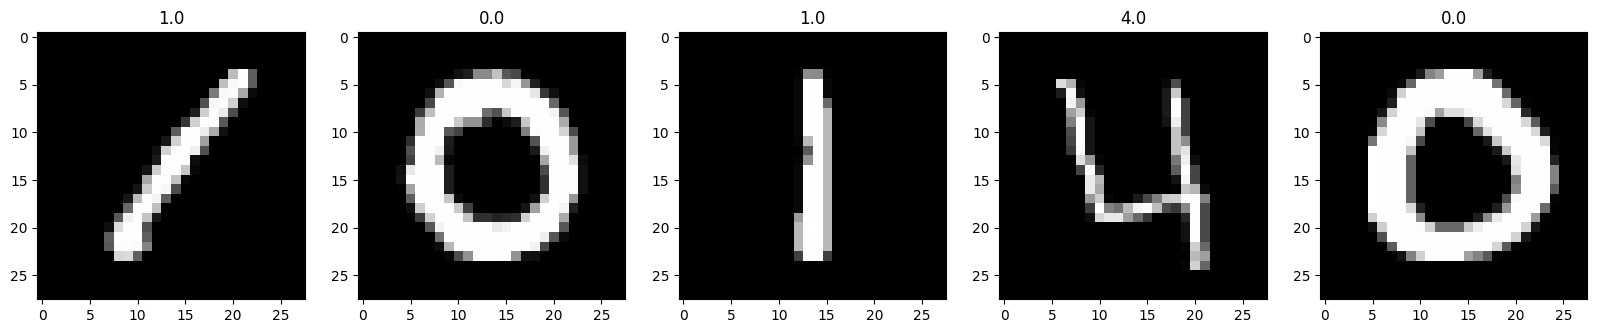

In [9]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [10]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img, test_size=0.2, random_state=42)

## Собираем сверточную сеть для обучения

In [11]:
model = keras.models.Sequential([
        keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=x_train.shape[1:]),
        keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
        keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
#######################################

        keras.layers.Flatten(),# (N,C,H,W) --> (N, C*H*W)
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                2

## One-hot кодировка разметки

In [14]:
y_train_labels = keras.utils.to_categorical(y_train)

In [15]:
print(y_train.shape)
print(y_train_labels.shape)

(33600,)
(33600, 10)


## Запускаем обучение

In [16]:
model.fit(x_train, 
          y_train_labels,
          batch_size=32, 
          epochs=5,
          validation_split=0.2)

Epoch 1/5
840/840 [==============================] - 9s 9ms/step - loss: 0.8167 - accuracy: 0.8619 - val_loss: 0.1845 - val_accuracy: 0.9496
Epoch 2/5
840/840 [==============================] - 8s 9ms/step - loss: 0.1278 - accuracy: 0.9617 - val_loss: 0.1231 - val_accuracy: 0.9643
Epoch 3/5
840/840 [==============================] - 8s 9ms/step - loss: 0.0834 - accuracy: 0.9742 - val_loss: 0.1215 - val_accuracy: 0.9661
Epoch 4/5
840/840 [==============================] - 8s 9ms/step - loss: 0.0655 - accuracy: 0.9802 - val_loss: 0.1208 - val_accuracy: 0.9686
Epoch 5/5
840/840 [==============================] - 8s 9ms/step - loss: 0.0542 - accuracy: 0.9827 - val_loss: 0.0994 - val_accuracy: 0.9757


## Предсказываем класс объекта

In [17]:
y_pred = model.predict(x_val)
y_pred_labels = np.argmax(y_pred, axis=1)

263/263 [==============================] - 1s 2ms/step


## Оцениваем качество решение на валидационной выборке

In [18]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred_labels))

Accuracy: 0.9776190476190476


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_labels))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       816
         1.0       0.98      0.99      0.98       909
         2.0       0.99      0.96      0.98       846
         3.0       0.97      0.98      0.97       937
         4.0       0.98      0.98      0.98       839
         5.0       0.97      0.98      0.97       702
         6.0       0.98      0.99      0.98       785
         7.0       0.98      0.98      0.98       893
         8.0       0.98      0.97      0.97       835
         9.0       0.97      0.97      0.97       838

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



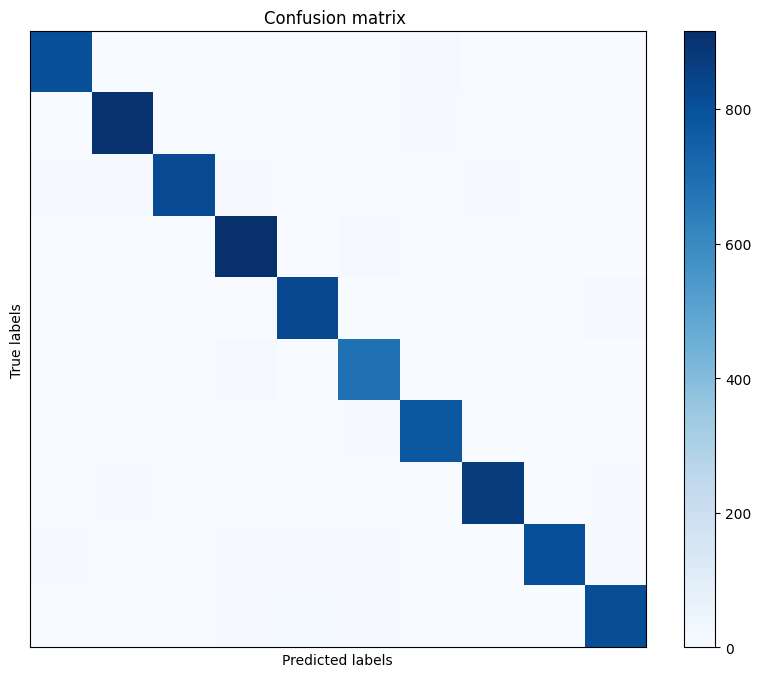

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

## Визуализируем предсказания для тестовой выборки

In [21]:
y_pred_test = model.predict(test_img)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

875/875 [==============================] - 2s 2ms/step


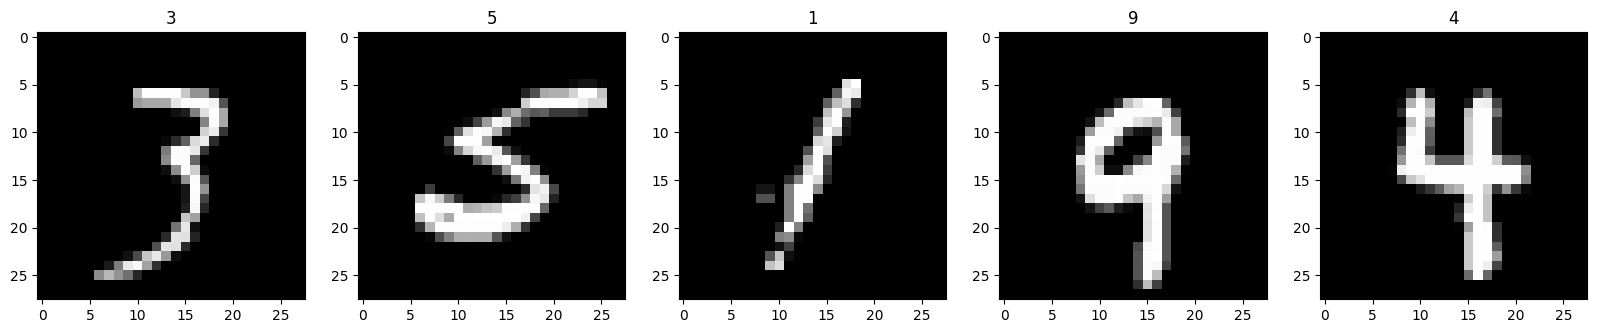

In [22]:
fig = plt.figure(figsize=(20, 10))
indices = np.random.choice(range(len(test_img)), 5)
img_prediction = zip(test_img[indices], y_pred_test_labels[indices])
for i, (img, pred) in enumerate(img_prediction, 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[...,0], cmap='gray');
    subplot.set_title('%d' % pred);

## Готовим файл для отправки

In [23]:
with open('Keras_lecture_3/submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test_labels, 1):
        dst.write('%s,%d\n' % (i, p))

In [ ]:
# Your submission scored 0.96814